In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
import xgboost as xgb

In [2]:
# Load the dataset
df = pd.read_csv('/Users/adityadeshpande/Desktop/others/Big Data Project/data 2.csv', encoding='ISO-8859-1')

# Drop missing rows for critical fields
df_clean = df.dropna(subset=['CustomerID', 'Description'])

# Remove negative and zero values for Quantity and UnitPrice
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

# Create TotalRevenue
df_clean['TotalRevenue'] = df_clean['Quantity'] * df_clean['UnitPrice']

# Drop irrelevant features
df_model = df_clean.drop(columns=['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate'])

# Aggregate by CustomerID
customer_agg = df_model.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'TotalRevenue': 'sum'
}).reset_index()

# Apply scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_agg[['Quantity', 'UnitPrice', 'TotalRevenue']])
scaled_df = pd.DataFrame(scaled_features, columns=['Quantity_scaled', 'UnitPrice_scaled', 'TotalRevenue_scaled'])
scaled_df['CustomerID'] = customer_agg['CustomerID'].values


In [3]:
scaled_df

,Quantity_scaled,UnitPrice_scaled,TotalRevenue_scaled,CustomerID
0,14.473038,-0.100205,8.358668,12346.0
1,0.251058,-0.053315,0.250966,12347.0
2,0.227869,0.037918,-0.028596,12348.0
3,-0.111047,0.111708,-0.033012,12349.0
4,-0.197065,-0.018318,-0.191347,12350.0
...,...,...,...,...
4333,-0.227190,0.008689,-0.208459,18280.0
4334,-0.225407,0.033767,-0.219560,18281.0
4335,-0.215695,0.021381,-0.208742,18282.0
4336,0.040771,-0.083396,0.004519,18283.0


In [4]:
# Ensure InvoiceDate is in datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'], errors='coerce')

# 1. Total Revenue over time
revenue_over_time = df_clean.groupby(df_clean['InvoiceDate'].dt.date)['TotalRevenue'].sum()

# 2. Top 10 Products by Total Revenue
top_products = df_clean.groupby('Description')['TotalRevenue'].sum().sort_values(ascending=False).head(10)

# 3. Top Returned Products (Quantity < 0)
returned_products = df[df['Quantity'] < 0].groupby('Description')['Quantity'].sum().sort_values().head(10)


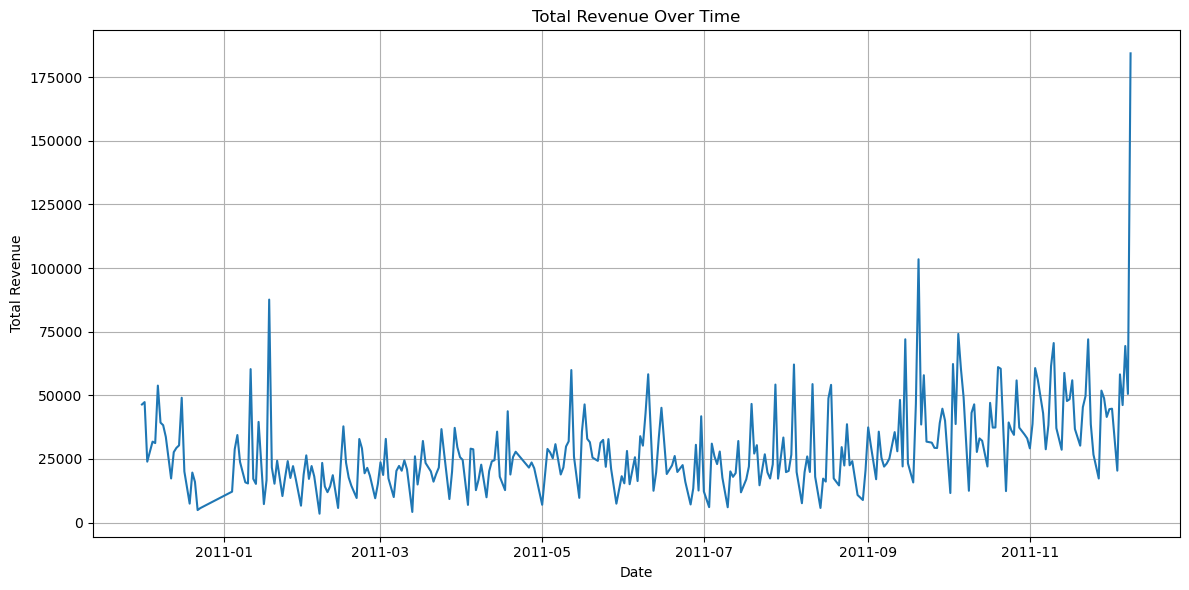

In [5]:
# Plot 1: Total Revenue over Time
plt.figure(figsize=(12, 6))
revenue_over_time.plot()
plt.title('Total Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.tight_layout()
plt.show()

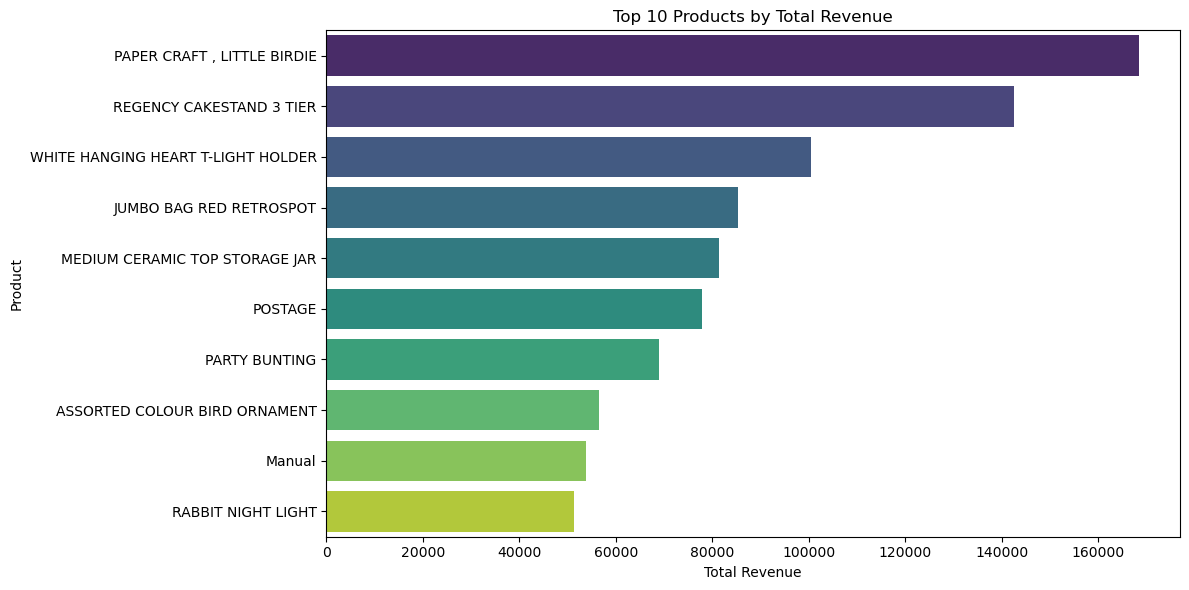

In [6]:
# Plot 2: Top 10 Products by Total Revenue
plt.figure(figsize=(12, 6))
sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")
plt.title('Top 10 Products by Total Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

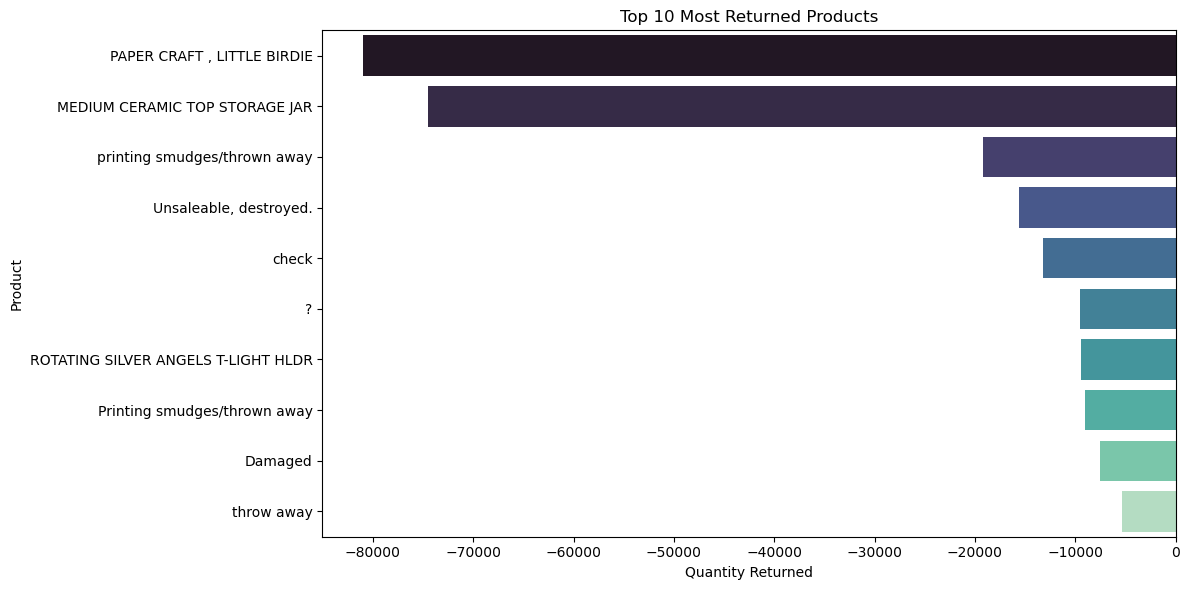

In [7]:
# Plot 3: Top 10 Returned Products
plt.figure(figsize=(12, 6))
sns.barplot(x=returned_products.values, y=returned_products.index, palette="mako")
plt.title('Top 10 Most Returned Products')
plt.xlabel('Quantity Returned')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

In [8]:
# Recreate the customer-level aggregated dataset
customer_agg = df_clean.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'TotalRevenue': 'sum'
}).reset_index()

# Define features and target
X = customer_agg[['Quantity', 'UnitPrice']]
y = customer_agg['TotalRevenue']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42)
}

# Evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),  # updated line for older sklearn
        "R2 Score": r2_score(y_test, y_pred)
    }

# Store results in DataFrame
results_df = pd.DataFrame(results).T.reset_index().rename(columns={"index": "Model"})

results_df


,Model,RMSE,R2 Score
0,Linear Regression,5766.850648,0.675365
1,Decision Tree,5252.532911,0.730688
2,Random Forest,5191.826644,0.736877


In [9]:


# Polynomial Linear Regression (degree 2)
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train, y_train)
y_pred_poly = poly_model.predict(X_test)

poly_results = {
    "Model": "Polynomial Regression (deg=2)",
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_poly)),
    "R2 Score": r2_score(y_test, y_pred_poly)
}


In [10]:


# Hyperparameter grid
dt_params = {
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Grid search with CV
dt_grid = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_params, cv=5, scoring='neg_mean_squared_error')
dt_grid.fit(X_train, y_train)
y_pred_dt = dt_grid.predict(X_test)

dt_results = {
    "Model": "Tuned Decision Tree",
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_dt)),
    "R2 Score": r2_score(y_test, y_pred_dt)
}


In [11]:
# Hyperparameter grid
rf_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5]
}

# Grid search with CV
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)
y_pred_rf = rf_grid.predict(X_test)

rf_results = {
    "Model": "Tuned Random Forest",
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    "R2 Score": r2_score(y_test, y_pred_rf)
}


In [12]:
# Combine all results
refined_models_df = pd.DataFrame([
    poly_results,
    dt_results,
    rf_results,
])

refined_models_df


,Model,RMSE,R2 Score
0,Polynomial Regression (deg=2),5670.044721,0.686172
1,Tuned Decision Tree,6077.282170,0.639473
2,Tuned Random Forest,5156.044292,0.740491


In [13]:


# Load and clean dataset

df_clean = df.dropna(subset=['CustomerID', 'Description'])
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]
df_clean['TotalRevenue'] = df_clean['Quantity'] * df_clean['UnitPrice']

# Aggregate by CustomerID
customer_agg = df_clean.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'TotalRevenue': 'sum'
}).reset_index()

# Feature engineering
customer_agg['AvgRevenuePerItem'] = customer_agg['TotalRevenue'] / customer_agg['Quantity']
customer_agg['LogQuantity'] = np.log1p(customer_agg['Quantity'])
customer_agg['LogRevenue'] = np.log1p(customer_agg['TotalRevenue'])
customer_agg['RevenuePerUnitPrice'] = customer_agg['TotalRevenue'] / customer_agg['UnitPrice']

# Define features and target
X = customer_agg[['LogQuantity', 'UnitPrice', 'AvgRevenuePerItem', 'RevenuePerUnitPrice']]
y = customer_agg['LogRevenue']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Polynomial Regression (degree=3, interaction only)
poly3_model = Pipeline([
    ('poly', PolynomialFeatures(degree=3, interaction_only=True)),
    ('lr', LinearRegression())
])
poly3_model.fit(X_train, y_train)
y_pred_poly = poly3_model.predict(X_test)
poly_results = {
    "Model": "Polynomial Regression (deg=3)",
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_poly)),
    "R2 Score": r2_score(y_test, y_pred_poly)
}

# Tuned Decision Tree with RandomizedSearchCV
dt_param_dist = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}
dt_random_search = RandomizedSearchCV(DecisionTreeRegressor(random_state=42), dt_param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
dt_random_search.fit(X_train, y_train)
y_pred_dt = dt_random_search.predict(X_test)
dt_results = {
    "Model": "Tuned Decision Tree",
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_dt)),
    "R2 Score": r2_score(y_test, y_pred_dt)
}

# Tuned Random Forest
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, None],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
rf_search = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_search.fit(X_train, y_train)
y_pred_rf = rf_search.predict(X_test)
rf_results = {
    "Model": "Tuned Random Forest",
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    "R2 Score": r2_score(y_test, y_pred_rf)
}

# Tuned XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_search = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_search.fit(X_train, y_train)
y_pred_xgb = xgb_search.predict(X_test)
xgb_results = {
    "Model": "Tuned XGBoost",
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
    "R2 Score": r2_score(y_test, y_pred_xgb)
}

# Combine all results
refined_models_df = pd.DataFrame([
    poly_results,
    dt_results,
    rf_results,
    xgb_results
])

# import ace_tools as tools; tools.display_dataframe_to_user(name="Refined Model Comparison", dataframe=refined_models_df)
refined_models_df


,Model,RMSE,R2 Score
0,Polynomial Regression (deg=3),0.206979,0.973278
1,Tuned Decision Tree,0.128856,0.989643
2,Tuned Random Forest,0.091306,0.994800
3,Tuned XGBoost,0.083330,0.995669
